<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [32]:
from utils import *

In [33]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

In [34]:
# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

In [35]:
# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


<div class="alert alert-block alert-success">

# **2.** **Models**

<div>

## **2.1** DistilBERT (Encoder)

In [ ]:
# Prepare Hugging Face Datasets
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"],truncation=True)

tokenized_datasets = dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)), ignore_mismatched_sizes=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=5,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="epoch",                    # Save model at the end of every epoch        
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

# Save model and tokenizer
trainer.save_model("distilbert-base-uncased")
tokenizer.save_pretrained("distilbert-base-uncased")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476000,0.424440,0.840230,0.841265,0.840230,0.840669
2,0.299000,0.403869,0.851755,0.850495,0.851755,0.851026


('distilbert-base-uncased/tokenizer_config.json',
 'distilbert-base-uncased/special_tokens_map.json',
 'distilbert-base-uncased/vocab.txt',
 'distilbert-base-uncased/added_tokens.json',
 'distilbert-base-uncased/tokenizer.json')

In [ ]:
# Get predictions on train and validation sets
train_preds_output = trainer.predict(tokenized_datasets["train"])
val_preds_output = trainer.predict(tokenized_datasets["validation"])

# Extract predicted labels
y_train_pred = np.argmax(train_preds_output.predictions, axis=1)
y_val_pred = np.argmax(val_preds_output.predictions, axis=1)

# Extract true labels
y_train = train_preds_output.label_ids
y_val = val_preds_output.label_ids

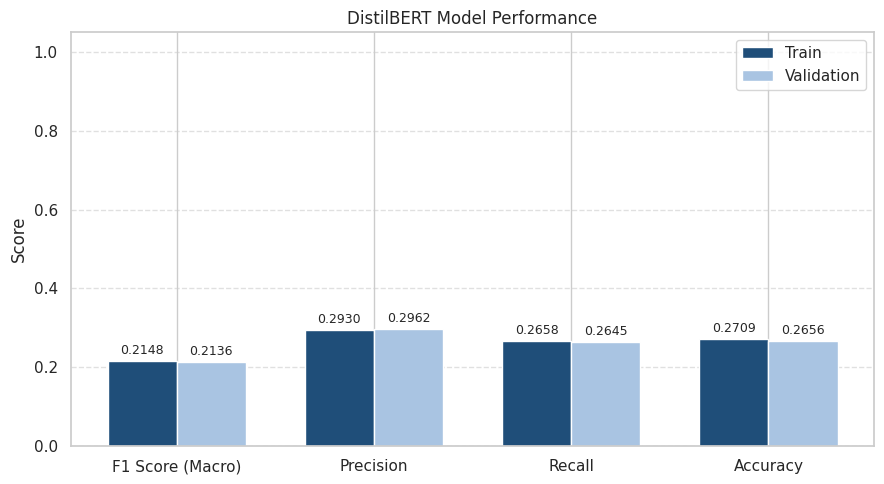

In [ ]:
plot_metrics(y_train, y_train_pred, y_val, y_val_pred, title="DistilBERT Model Performance")

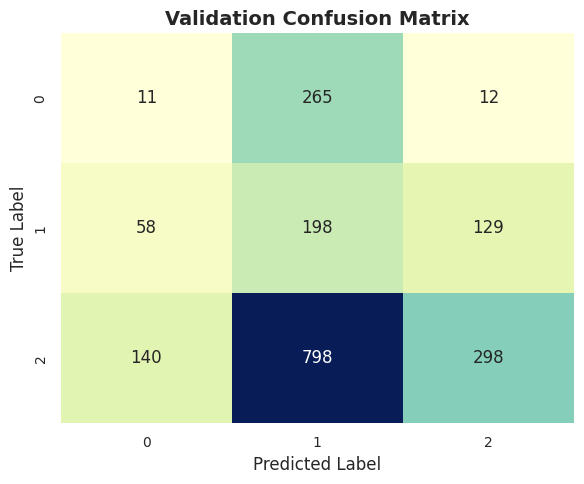

In [ ]:
# Provide label names
plot_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix", labels=[0,1,2])

In [ ]:
df_metrics = get_metrics_df("DistilBERT", y_train, y_train_pred, y_val, y_val_pred)
df_metrics

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,DistilBERT,0.2148,0.2136,0.293,0.2962,0.2658,0.2645,0.2709,0.2656


## **2.2** RoBERTa (Encoder) - EXTRA

### **2.2.1** Setup

In [6]:
# Prepare Hugging Face Datasets
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

In [7]:
# Load RoBERTa tokenizer and model (no sentiment head)
model_checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=5,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="epoch",                    # Save model at the end of every epoch        
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [10]:
# Define metrics
def trainer_compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Data collator for truncation and padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### **2.2.2** Train and Validate

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=trainer_compute_metrics
)

# Train the model
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.039200,0.853240,0.878470,0.884776,0.878470,0.880082
2,0.149900,0.742684,0.875851,0.880145,0.875851,0.876691
3,0.132800,0.643052,0.891566,0.890514,0.891566,0.890723
4,0.033200,0.757844,0.888423,0.889079,0.888423,0.888708
5,0.050100,0.814385,0.884233,0.888757,0.884233,0.885644


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pin

TrainOutput(global_step=2390, training_loss=0.07231285018402163, metrics={'train_runtime': 2121.8095, 'train_samples_per_second': 17.989, 'train_steps_per_second': 1.126, 'total_flos': 2011082741521056.0, 'train_loss': 0.07231285018402163, 'epoch': 5.0})

In [20]:
# Save model and tokenizer
trainer.save_model("roberta-market-sentiment")
tokenizer.save_pretrained("roberta-market-sentiment")

('roberta-market-sentiment/tokenizer_config.json',
 'roberta-market-sentiment/special_tokens_map.json',
 'roberta-market-sentiment/vocab.json',
 'roberta-market-sentiment/merges.txt',
 'roberta-market-sentiment/added_tokens.json',
 'roberta-market-sentiment/tokenizer.json')

In [15]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training Set Evaluation Metrics:
eval_loss: 0.0139
eval_accuracy: 0.9967
eval_precision: 0.9967
eval_recall: 0.9967
eval_f1: 0.9967
eval_runtime: 97.0996
eval_samples_per_second: 78.6200
eval_steps_per_second: 2.4610
epoch: 5.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Set Evaluation Metrics:
eval_loss: 0.8144
eval_accuracy: 0.8842
eval_precision: 0.8888
eval_recall: 0.8842
eval_f1: 0.8856
eval_runtime: 21.0067
eval_samples_per_second: 90.8760
eval_steps_per_second: 2.8560
epoch: 5.0000


In [17]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_roberta = np.argmax(train_preds.predictions, axis=1)
val_pred_roberta = np.argmax(val_preds.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [16]:
# Define the title for the metrics and plots
title = "Roberta Market Sentiment"

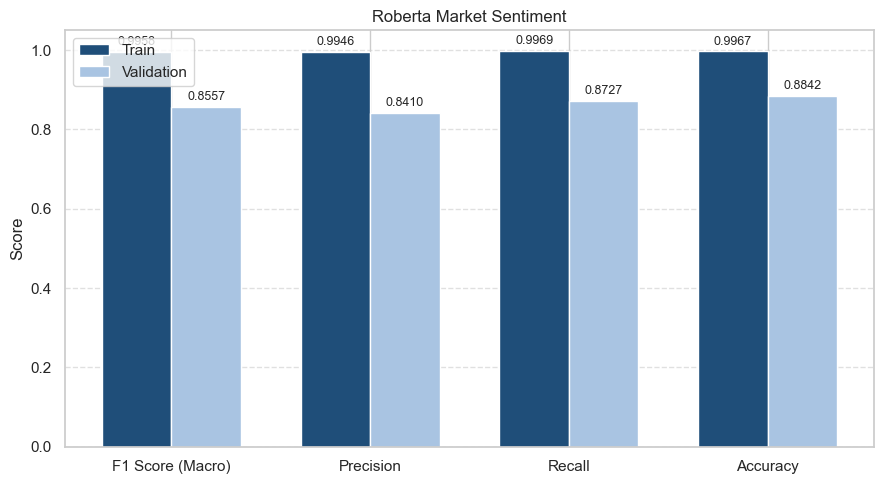

In [18]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_roberta, val_labels, val_pred_roberta)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_roberta, val_labels, val_pred_roberta, title=title)

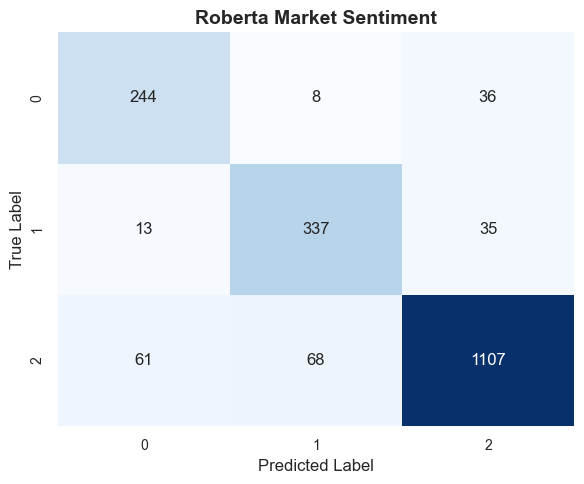

In [19]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.3** GPT-4o (Decoder) - EXTRA

In [36]:
# Convert Series to list and ensure labels are strings
train_labels = [str(label) for label in data_no_preproc['y_train'].tolist()]
val_labels = [str(label) for label in data_no_preproc['y_val'].tolist()]

In [37]:
# Label options
label_options = sorted(list(set(train_labels)))

# Generate few-shot examples
few_shot_examples = []
for label in label_options:
    examples = [(t, l) for t, l in zip(train_texts, train_labels) if l == label]
    sample = random.choice(examples)
    few_shot_examples.append({'text': sample[0], 'label': sample[1]})

# Print few-shot examples
print("Few-shot examples:")
for example in few_shot_examples:
    print(f"Text: {example['text']}, Label: {example['label']}")

Few-shot examples:
Text: Phathom Pharmaceuticals EPS of -$9.30, Label: 0
Text: JPMorgan likes Bausch Health in premarket analyst action, Label: 1
Text: Penn Station Stinks, But the Neighborhood Is Looking Up, Label: 2


In [ ]:
# Run (or load cached) classification
train_pred_gpt4o = cached_classification_run("gpt4o_train_preds.pkl", train_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)
val_pred_gpt4o = cached_classification_run("gpt4o_val_preds.pkl", val_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)

No cache found. Running classification and saving to gpt4o_train_preds.pkl


Classifying with GPT-4o:   5%|▌         | 25/478 [11:01<3:20:36, 26.57s/it]

Error on input 'How to Make a Killing During t...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  16%|█▌        | 75/478 [33:03<2:55:35, 26.14s/it]

Error on input 'Sanders Targets Buttigieg Over...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  19%|█▉        | 90/478 [39:40<2:51:53, 26.58s/it]

Error on input 'Here's why this video showing ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  39%|███▉      | 186/478 [1:22:15<2:09:28, 26.61s/it]

Error on input '$hdge shorts getting killed to...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  49%|████▉     | 234/478 [1:43:38<1:48:02, 26.57s/it]

Error on input 'Botswana Sells Rights to Kill ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  57%|█████▋    | 271/478 [1:59:58<1:33:01, 26.96s/it]

Error on input 'Secret documents reveal how Ch...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  65%|██████▌   | 312/478 [2:18:13<1:12:48, 26.31s/it]

Error on input 'Who’s coming to #RVAilluminate...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}}}}}


Classifying with GPT-4o:  69%|██████▉   | 330/478 [2:26:13<1:06:46, 27.07s/it]

Error on input 'At dinner, man in a wheelchair...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'medium'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  95%|█████████▌| 456/478 [3:22:12<09:45, 26.60s/it]  

Error on input 'Queen Cancels Prince Andrew's ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'low'}}}}}


Classifying with GPT-4o: 100%|██████████| 478/478 [3:31:33<00:00, 26.55s/it]


No cache found. Running classification and saving to gpt4o_val_preds.pkl


Classifying with GPT-4o:   2%|▎         | 3/120 [01:17<50:29, 25.89s/it]

Error on input 'Teeny tiny martinis are taking...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  94%|█████████▍| 113/120 [49:56<03:05, 26.52s/it]

Error on input 'Wayfair stumbles after Citron ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o: 100%|██████████| 120/120 [52:42<00:00, 26.35s/it]


In [ ]:
# # Filter out unkown labels from both predictions and labels before computing metrics
# clean_preds = []
# clean_labels = []

# for pred, label in zip(train_pred_gpt4o, train_labels):
#     if pred != "unknown":
#         clean_preds.append(pred)
#         clean_labels.append(label)

In [38]:
# Run (or load cached) classification
train_pred_gpt4o = cached_classification_run("gpt4o_train_preds.pkl", train_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)
val_pred_gpt4o = cached_classification_run("gpt4o_val_preds.pkl", val_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)

Loading cached results from gpt4o_train_preds.pkl
Loading cached results from gpt4o_val_preds.pkl


In [39]:
# Convert to np.array
X_train_gpt40 = np.array(train_pred_gpt4o)
X_val_gpt40 = np.array(val_pred_gpt4o)

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [40]:
# Define the title for the metrics and plots
title = "GPT-4o with Few-shot Examples"

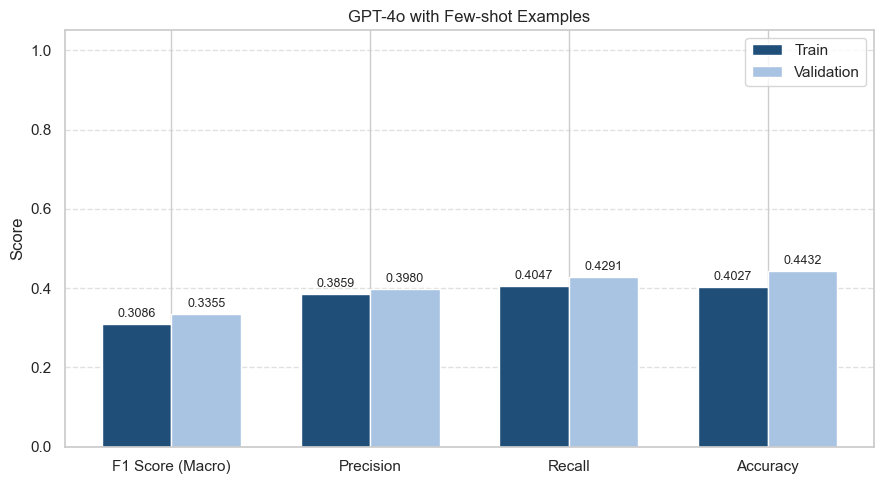

In [41]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o, title=title)

In [43]:
# # Plot confusion matrix
# plot_confusion_matrix(val_labels, val_pred_gpt4o, title=title, labels=[0, 1, 2], cmap="Blues")